### Pre-Proposal

#### _

###Project Title:

Implementing and Extending a Multi-Modal Large Language Model for Protein Function Prediction


###Team Members:


Thomas Haskell
Mohammed Alnajim
Conor Jurewicz
(Conceptualization): Defines the research questions and overall project direction.
(Writing): Leads the writing, ensuring clarity in documentation.
(Methodology): Designs the model architecture and training strategy.
(Validation): Oversees testing and performance metrics, ensuring the model’s reliability.
(Software Development): Implements the data preprocessing pipeline, model codebase, and integration scripts.
(Visualization): Creates and refines plots, tables that illustrate model performance and outputs.
###Problem Statement:

The attached paper “Multi-Modal Large Language Model Enables Protein Function Prediction” (Huo et al., 2024) introduces a unified approach for predicting protein functions using a multi-modal large language model. This approach allows the model to output free-form descriptions of protein function, capturing more nuanced biological detail than methods limited to discrete categories alone. Still, there are persistent issues, such as handling ambiguous data, achieving high verifiability of predictions, and dealing with potentially novel but currently unverified protein functions.


###Proposed Solution:


Enhancement of Fine-Tuning Strategy: We aim to improve the model’s correctness for lesser-known proteins by exploring alternative instruction-tuning prompts or additional curated examples from the same Swiss-Prot data source referenced in the paper.


Performance Benchmarks: As described in the paper, we will evaluate free-form text outputs (against curated Swiss-Prot annotations) and discrete function categories (like catalytic type, ligand binding) to measure accuracy and F1 scores.
Core Novelty:
We will focus on improving precision for partially correct outputs, possibly by integrating a confidence scoring mechanism that flags uncertain answers for further user probing.
Technologies to Be Used:


Protein Encoder: xTrimoPGLM (as in the paper).
Large Language Model: Vicuna-based model (as in the paper).
Data: Swiss-Prot dataset for curated protein-function annotations, with additional filtering steps to strengthen data quality.
Implementation Stack: Python and PyTorch for training; minimal changes to the paper’s methodology to maintain comparability.


###Expected Output / Deliverables:


Extended Multi-Modal LLM: A refined system capable of protein-function predictions in both free-form text and discrete categories, building directly on the paper’s model.
Accuracy and F1 Comparisons: Tables and charts showing performance on Swiss-Prot test proteins, focusing on where improvements occur.


###Challenges / Open Questions:


Handling Novel Proteins: The paper notes that purely sequence-based predictions may be limited if there is minimal existing data. We must still address how to refine or confirm predictions for rarely characterized proteins.
Balancing Free-Form Output and Accuracy: Free-form text is expressive, but may include inaccuracies. The best way to filter or highlight uncertain segments remains an open issue.
Computational Cost: Training and fine-tuning large models can be resource-intensive; careful planning of training schedules is critical to manage runtime.


###References:
Huo, M., Guo, H., Cheng, X., Singh, D., Rahmani, H., Li, S., Gerlof, P., Ideker, T., Grotjahn, D.A., Villa, E., Song, L., & Xie, P. (2024). Multi-Modal Large Language Model Enables Protein Function Prediction. bioRxiv.


## Analysis

### Step 1: Install dependencies

In [ ]:
#!pip install torch torchvision torchaudio
#!pip install transformers datasets sentencepiece
#!pip install matplotlib pandas tqdm omegaconf iopath decord webdataset
#!pip install -U bitsandbytes

### Step 2: Unzip project and data files

In [ ]:
#!unzip -q /content/ProteinChat-main.zip -d /content/ProteinChat-main
#!unzip -q /content/data.zip -d /content/data

In [ ]:
#!find /content/data -type f -name "*.json"

### Step 3: Run inference

In [ ]:
%cd /content/ProteinChat-main/ProteinChat-main
!python inference_all.py

/content/ProteinChat-main/ProteinChat-main
/usr/local/lib/python3.11/dist-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
2025-04-08 08:46:00.766156: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744101960.786819   60397 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744101960.793110   60397 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-08 08:46:00.813864: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available C

### Step 4: Download results

###Data Preprocessing

In [ ]:
import json
import os
import pandas as pd
from tqdm import tqdm

# -----------------------------
# Step 1. Function to Load JSON Data
# -----------------------------
def load_json_data(folder_path, skip_files=None, max_files=5, records_per_file=10):
    """
    Loads up to max_files JSON files from a folder into a DataFrame.
    For each file that contains a list of dictionaries, it only processes the first
    records_per_file items to speed up testing.

    Parameters:
      folder_path (str): The directory containing JSON files.
      skip_files (list): Filenames to skip (e.g., ["uniprot_ids.json"]).
      max_files (int): Maximum number of files to process (useful for testing).
      records_per_file (int): Maximum number of records to read from each file.

    Returns:
      DataFrame: A Pandas DataFrame with the loaded records.
    """
    if skip_files is None:
        skip_files = []
    data = []

    # Gather list of JSON files in the folder, skipping any undesired files.
    files = [filename for filename in os.listdir(folder_path)
             if filename.endswith(".json") and filename not in skip_files]

    # Optionally limit processing to a maximum number of files.
    if max_files is not None:
        files = files[:max_files]

    # Process each file with a progress bar.
    for filename in tqdm(files, desc="Processing JSON files"):
        file_path = os.path.join(folder_path, filename)
        try:
            with open(file_path, 'r') as f:
                content = json.load(f)
        except Exception as e:
            print(f"Error processing file {filename}: {e}")
            continue

        # If content is a list of dictionaries, take only the first records_per_file items.
        if isinstance(content, list):
            if len(content) > 0 and isinstance(content[0], dict):
                data.extend(content[:records_per_file])
            else:
                print(f"Skipping file {filename} because it does not contain dictionary records.")
        # If content is a single dictionary, add it as one record.
        elif isinstance(content, dict):
            data.append(content)
        else:
            print(f"Skipping file {filename} because its content is neither a list nor a dictionary.")

    # Convert the data list into a DataFrame.
    df = pd.DataFrame(data)
    print(f"Total records loaded from {folder_path} (using up to {max_files} files and {records_per_file} records per file): {len(df)}")
    return df

# -----------------------------
# Step 2. Define Your Folders and Load the Data
# -----------------------------
# Define the folder paths
train_folder = '/content/data/data/train_set' # For model learning (with pre-processing and possible additional constraints for handling noisy data).
val_folder = '/content/data/data/valid_set'  # For tuning and monitoring the model during training.
test_folder = '/content/data/data/test_set' # For a final, unbiased evaluation of your model’s performance.

# Specify files to skip (e.g., skip "uniprot_ids.json" since it only contains plain strings)
skip_files = ["uniprot_ids.json"]

# For testing purposes, process a limited number of files (set max_files and records_per_file to small numbers)
train_df = load_json_data(train_folder, skip_files=skip_files, max_files=5, records_per_file=10)
val_df = load_json_data(val_folder, skip_files=skip_files, max_files=5, records_per_file=10)
test_df = load_json_data(test_folder, skip_files=skip_files, max_files=5, records_per_file=10)

# -----------------------------
# Step 3. Inspect the Loaded Data
# -----------------------------
# Temporarily limit the output display to a few columns for clarity.
pd.set_option('display.max_columns', 10)

print("\nTraining set sample (first 5 rows, first 10 columns):")
print(train_df.iloc[:5, :10])

# Print a list of all column names and the total number of columns.
all_columns = train_df.columns.tolist()
print("\nTotal number of columns in the train_df:", len(all_columns))
print("First 20 column names:", all_columns[:20])

# -----------------------------
# Step 4. Create a Subset DataFrame for Key Fields
# -----------------------------
# Suppose the key fields you need are 'uniprot_id' and 'caption'.
if 'uniprot_id' in train_df.columns and 'caption' in train_df.columns:
    train_df_subset = train_df[['uniprot_id', 'caption']]
    print("\nTraining set subset (only 'uniprot_id' and 'caption'):")
    print(train_df_subset.head())
else:
    print("\nEither 'uniprot_id' or 'caption' is not present in the training data columns.")

# Similarly, you can inspect validation and test sets:
print("\nValidation set sample:")
print(val_df.head())
print("\nTest set sample:")
print(test_df.head())

Processing JSON files: 100%|██████████| 4/4 [00:06<00:00,  1.55s/it]


Total records loaded from /content/data/data/train_set (using up to 5 files and 10 records per file): 31


Processing JSON files: 100%|██████████| 4/4 [00:00<00:00, 13.48it/s]


Total records loaded from /content/data/data/valid_set (using up to 5 files and 10 records per file): 31


Processing JSON files: 100%|██████████| 4/4 [00:00<00:00, 18.07it/s]


Total records loaded from /content/data/data/test_set (using up to 5 files and 10 records per file): 31

Training set sample (first 5 rows, first 10 columns):
   uniprot_id                                            caption    Q  Q_id  \
0      P86525  This protein is a heterotrimeric snake venom p...  NaN   NaN   
1  A0A044RE18  Serine endoprotease which cleaves substrates a...  NaN   NaN   
2  A0A059TC02  This protein is involved in the latter stages ...  NaN   NaN   
3  A0A060A682  This protein, HAP2, is crucial for the formati...  NaN   NaN   
4  A0A061ACU2  This protein is a pore-forming subunit of a me...  NaN   NaN   

     A B1Z888 O00192 P61086 Q0I4A3 B9SCX0  
0  NaN    NaN    NaN    NaN    NaN    NaN  
1  NaN    NaN    NaN    NaN    NaN    NaN  
2  NaN    NaN    NaN    NaN    NaN    NaN  
3  NaN    NaN    NaN    NaN    NaN    NaN  
4  NaN    NaN    NaN    NaN    NaN    NaN  

Total number of columns in the train_df: 503682
First 20 column names: ['uniprot_id', 'caption', 'Q',

In [ ]:
!grep protein_dim configs/proteinchat_eval.yaml

  protein_dim: 1280      # ✅ ESM2-650M output


In [ ]:
if 'uniprot_id' in train_df.columns and 'caption' in train_df.columns:
    train_df_subset = train_df[['uniprot_id', 'caption']]
else:
    print("Either 'uniprot_id' or 'caption' is missing in the training data.")

# Check the first few records and list the columns.
print("Train set subset sample:")
print(train_df_subset.head())

print("\nColumns in the training subset:")
print(train_df_subset.columns.tolist())

# Get basic statistics on the 'caption' field
print("\nBasic stats for 'caption':")
print(train_df_subset['caption'].describe(include='all'))

# Check for missing values in key columns
print("\nMissing values:")
print(train_df_subset[['uniprot_id', 'caption']].isnull().sum())

Train set subset sample:
   uniprot_id                                            caption
0      P86525  This protein is a heterotrimeric snake venom p...
1  A0A044RE18  Serine endoprotease which cleaves substrates a...
2  A0A059TC02  This protein is involved in the latter stages ...
3  A0A060A682  This protein, HAP2, is crucial for the formati...
4  A0A061ACU2  This protein is a pore-forming subunit of a me...

Columns in the training subset:
['uniprot_id', 'caption']

Basic stats for 'caption':
count                                                    20
unique                                                   20
top       This protein is a heterotrimeric snake venom p...
freq                                                      1
Name: caption, dtype: object

Missing values:
uniprot_id     1
caption       11
dtype: int64



Caption length statistics:
count     20.000000
mean     204.400000
std       71.134713
min       40.000000
25%      159.750000
50%      218.500000
75%      259.250000
max      320.000000
Name: caption_length, dtype: float64


<ipython-input-8-22ea2f699ec8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_subset['caption_clean'] = train_df_subset['caption'].str.lower().str.strip()
<ipython-input-8-22ea2f699ec8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_subset['caption_length'] = train_df_subset['caption_clean'].str.len()


<Axes: >

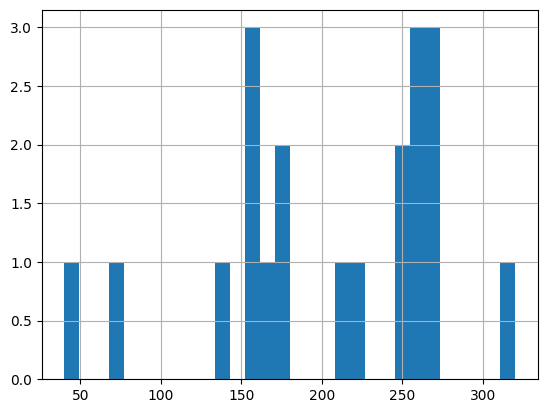

In [ ]:
# Create a cleaned caption column
train_df_subset['caption_clean'] = train_df_subset['caption'].str.lower().str.strip()

# Calculate the length of each caption for exploratory analysis
train_df_subset['caption_length'] = train_df_subset['caption_clean'].str.len()

# Display statistics about text lengths
print("\nCaption length statistics:")
print(train_df_subset['caption_length'].describe())

# (Optional) Plot the distribution of caption lengths using pandas built-in plotting:
train_df_subset['caption_length'].hist(bins=30)

In [ ]:
# Create a new column 'prompt' using the 'uniprot_id'
train_df_subset['prompt'] = "Describe the function of protein " + train_df_subset['uniprot_id'] + "."

# Display a few triplets (uniprot_id, prompt, cleaned caption)
sample_triplets = train_df_subset[['uniprot_id', 'prompt', 'caption_clean']].head(10)
print("\nSample training triplets:")
print(sample_triplets)


Sample training triplets:
   uniprot_id                                        prompt  \
0      P86525      Describe the function of protein P86525.   
1  A0A044RE18  Describe the function of protein A0A044RE18.   
2  A0A059TC02  Describe the function of protein A0A059TC02.   
3  A0A060A682  Describe the function of protein A0A060A682.   
4  A0A061ACU2  Describe the function of protein A0A061ACU2.   
5  A0A061AE05  Describe the function of protein A0A061AE05.   
6  A0A061I403  Describe the function of protein A0A061I403.   
7  A0A067CMC7  Describe the function of protein A0A067CMC7.   
8  A0A067XGX8  Describe the function of protein A0A067XGX8.   
9  A0A067XH53  Describe the function of protein A0A067XH53.   

                                       caption_clean  
0  this protein is a heterotrimeric snake venom p...  
1  serine endoprotease which cleaves substrates a...  
2  this protein is involved in the latter stages ...  
3  this protein, hap2, is crucial for the formati...  
4  t

<ipython-input-9-36e94d57d24b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df_subset['prompt'] = "Describe the function of protein " + train_df_subset['uniprot_id'] + "."


In [ ]:
# Save the cleaned and subset data to CSV (or JSON) for later use.
train_df_subset.to_csv('/content/processed_train_subset.csv', index=False)
print("\nProcessed training subset saved to '/content/processed_train_subset.csv'.")


Processed training subset saved to '/content/processed_train_subset.csv'.


## As-is Implementaiton


In [1]:
!pip install -U iopath decord webdataset deepspeed bitsandbytes omegaconf cpm_kernels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 122.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.6/416.6 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# After running this, you'll get a URL to authenticate and get a code.
# Enter the code in the prompt to finish mounting.


In [ ]:
%%bash

# --- DEFINE GOOGLE DRIVE SOURCE DIRECTORY ---
DRIVE_SOURCE_PATH="/content/drive/MyDrive/Colab Notebooks/proteinchat_files"
# --- COLAB TARGET PARENT DIRECTORY ---
COLAB_DEST_PARENT_PATH="/content"

echo "Starting to copy 10 folders from $DRIVE_SOURCE_PATH to $COLAB_DEST_PARENT_PATH"
echo "This process will take a very long time."

# --- Direct copy commands for each folder ---

echo "1. Copying ProteinChat..."
cp -rv "$DRIVE_SOURCE_PATH/ProteinChat" "$COLAB_DEST_PARENT_PATH/"

echo "2. Copying bert_base_uncased_tokenizer_files..."
cp -rv "$DRIVE_SOURCE_PATH/bert_base_uncased_tokenizer_files" "$COLAB_DEST_PARENT_PATH/"

echo "3. Copying cache..."
cp -rv "$DRIVE_SOURCE_PATH/cache" "$COLAB_DEST_PARENT_PATH/"

echo "4. Copying my_hf_cache..."
cp -rv "$DRIVE_SOURCE_PATH/my_hf_cache" "$COLAB_DEST_PARENT_PATH/"

echo "5. Copying my_hf_cache_bert..."
cp -rv "$DRIVE_SOURCE_PATH/my_hf_cache_bert" "$COLAB_DEST_PARENT_PATH/"

echo "6. Copying proteinchat_output_stage1..."
cp -rv "$DRIVE_SOURCE_PATH/proteinchat_output_stage1" "$COLAB_DEST_PARENT_PATH/"

echo "7. Copying proteinchat_output_stage2..."
cp -rv "$DRIVE_SOURCE_PATH/proteinchat_output_stage2" "$COLAB_DEST_PARENT_PATH/"

echo "8. Copying proteinchat_weights..."
cp -rv "$DRIVE_SOURCE_PATH/proteinchat_weights" "$COLAB_DEST_PARENT_PATH/"

echo "9. Copying vicuna_13b..."
cp -rv "$DRIVE_SOURCE_PATH/vicuna_13b" "$COLAB_DEST_PARENT_PATH/"

echo "10. Copying xtrimopglm_1b_mlm..."
cp -rv "$DRIVE_SOURCE_PATH/xtrimopglm_1b_mlm" "$COLAB_DEST_PARENT_PATH/"

echo "File restoration from Drive to Colab complete."

Starting to copy 10 folders from /content/drive/MyDrive/Colab Notebooks/proteinchat_files to /content
This process will take a very long time.
1. Copying ProteinChat...
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat' -> '/content/ProteinChat'
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat/.git' -> '/content/ProteinChat/.git'
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat/.git/info' -> '/content/ProteinChat/.git/info'
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat/.git/info/exclude' -> '/content/ProteinChat/.git/info/exclude'
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat/.git/branches' -> '/content/ProteinChat/.git/branches'
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat/.git/hooks' -> '/content/ProteinChat/.git/hooks'
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat/.git/hooks/pre-commit.sample' -> '/content/ProteinChat/.git/hoo

In [ ]:
from google.colab import drive

# Unmount Google Drive
drive.flush_and_unmount()


In [ ]:
%%bash
cd /content/ProteinChat
bash demo.sh

[2025-05-13 17:33:19,903] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Initializing Chat
| distributed init (rank 0, world 1): env://
Loading protein encoder
Start Low Resource Mode
Load GLM and LP Checkpoint: /content/proteinchat_weights/proteinchat_glm.pth
Initialization Finished
Uniprot ID: A0A097I2D0
Correct Function: Histone-like protein that is recruited to viral factories during viral replication and participates in viral DNA packaging and virion production probably by forming unstable nucleosome-like particles. May compact the viral DNA
Predicted Function: This protein is a histone-like protein that is involved in the assembly of nucleosomes and chromatin, and is required for proper DNA replication and chromosomal stability.
Uniprot ID: A0A098D1N7
Correct Function: This protein is part of a gene cluster involved in the biosynthesis of gramillins A and B, bicyclic lipopeptides that induce cell death in maize leaves.
Predicted Func

/usr/local/lib/python3.11/dist-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
2025-05-13 17:33:16.525075: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-13 17:33:16.548360: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747157596.570857   34239 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747157596.577854   34239 cuda_blas.cc:1418] Unabl

CalledProcessError: Command 'b'cd /content/ProteinChat\nbash demo.sh\n'' returned non-zero exit status 1.

## Prompt Enginerring and Decoding Parameters Tuning

In [2]:
%%bash

# --- DEFINE GOOGLE DRIVE SOURCE DIRECTORY ---
DRIVE_SOURCE_PATH="/content/drive/MyDrive/Colab Notebooks/proteinchat_files"
# --- COLAB TARGET PARENT DIRECTORY ---
COLAB_DEST_PARENT_PATH="/content"

echo "Starting to copy 10 folders from $DRIVE_SOURCE_PATH to $COLAB_DEST_PARENT_PATH"
echo "This process will take a very long time."

# --- Direct copy commands for each folder ---

echo "1. Copying ProteinChat..."
cp -rv "$DRIVE_SOURCE_PATH/ProteinChat" "$COLAB_DEST_PARENT_PATH/"

echo "2. Copying bert_base_uncased_tokenizer_files..."
cp -rv "$DRIVE_SOURCE_PATH/bert_base_uncased_tokenizer_files" "$COLAB_DEST_PARENT_PATH/"

echo "3. Copying cache..."
cp -rv "$DRIVE_SOURCE_PATH/cache" "$COLAB_DEST_PARENT_PATH/"

echo "4. Copying my_hf_cache..."
cp -rv "$DRIVE_SOURCE_PATH/my_hf_cache" "$COLAB_DEST_PARENT_PATH/"

echo "5. Copying my_hf_cache_bert..."
cp -rv "$DRIVE_SOURCE_PATH/my_hf_cache_bert" "$COLAB_DEST_PARENT_PATH/"

echo "6. Copying proteinchat_output_stage1..."
cp -rv "$DRIVE_SOURCE_PATH/proteinchat_output_stage1" "$COLAB_DEST_PARENT_PATH/"

echo "7. Copying proteinchat_output_stage2..."
cp -rv "$DRIVE_SOURCE_PATH/proteinchat_output_stage2" "$COLAB_DEST_PARENT_PATH/"

echo "8. Copying proteinchat_weights..."
cp -rv "$DRIVE_SOURCE_PATH/proteinchat_weights" "$COLAB_DEST_PARENT_PATH/"

echo "9. Copying vicuna_13b..."
cp -rv "$DRIVE_SOURCE_PATH/vicuna_13b" "$COLAB_DEST_PARENT_PATH/"

echo "10. Copying xtrimopglm_1b_mlm..."
cp -rv "$DRIVE_SOURCE_PATH/xtrimopglm_1b_mlm" "$COLAB_DEST_PARENT_PATH/"

echo "File restoration from Drive to Colab complete."

Starting to copy 10 folders from /content/drive/MyDrive/Colab Notebooks/proteinchat_files to /content
This process will take a very long time.
1. Copying ProteinChat...
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat' -> '/content/ProteinChat'
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat/.git' -> '/content/ProteinChat/.git'
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat/.git/info' -> '/content/ProteinChat/.git/info'
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat/.git/info/exclude' -> '/content/ProteinChat/.git/info/exclude'
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat/.git/branches' -> '/content/ProteinChat/.git/branches'
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat/.git/hooks' -> '/content/ProteinChat/.git/hooks'
'/content/drive/MyDrive/Colab Notebooks/proteinchat_files/ProteinChat/.git/hooks/pre-commit.sample' -> '/content/ProteinChat/.git/hoo

### Default prompts:

> questions = ["Tell me about this protein.",
                "What is the functionality of this protein?",
                "Briefly summarize the functionality of this protein.",
                "Please provide a detailed description of the protein."]

### Adjusted prompts:

> questions = ["What is the protein's molecular function?",
                "Which biological process is this protein involved in?",
                "Where in the cell does this protein function?",
                "What does this protein interact with?"]


### Default encoding parameters:
>  - "temperature": 0.9
>  - "top_p": 0.6


In [ ]:
%%bash
cd /content/ProteinChat
bash demo.sh

[2025-05-17 03:16:52,256] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Initializing Chat
| distributed init (rank 0, world 1): env://
Loading protein encoder
Start Low Resource Mode
Load GLM and LP Checkpoint: /content/proteinchat_weights/proteinchat_glm.pth
Initialization Finished
Uniprot ID: A0A097I2D0
Correct Function: Histone-like protein that is recruited to viral factories during viral replication and participates in viral DNA packaging and virion production probably by forming unstable nucleosome-like particles. May compact the viral DNA
Predicted Function: This protein is involved in the assembly and function of the central component of the nuclear lamina, which is composed of interwoven heterotrimeric nucleosomes and lamin proteins.
Uniprot ID: A0A098D1N7
Correct Function: This protein is part of a gene cluster involved in the biosynthesis of gramillins A and B, bicyclic lipopeptides that induce cell death in maize leaves.
Predi

/usr/local/lib/python3.11/dist-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
2025-05-17 03:16:49.242134: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 03:16:49.260153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747451809.282231   15615 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747451809.288823   15615 cuda_blas.cc:1418] Unabl

CalledProcessError: Command 'b'cd /content/ProteinChat\nbash demo.sh\n'' returned non-zero exit status 1.

### Adjusted prompts:

> questions = ["What is the protein's molecular function?",
                "Which biological process is this protein involved in?",
                "Where in the cell does this protein function?",
                "What does this protein interact with?"]
                
### Adjusted encoding parameters:
>  - "temperature": 0.5
>  - "top_p": 0.9

In [ ]:
%%bash
cd /content/ProteinChat
bash demo.sh

[2025-05-17 05:29:48,140] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Initializing Chat
| distributed init (rank 0, world 1): env://
Loading protein encoder
Start Low Resource Mode
Load GLM and LP Checkpoint: /content/proteinchat_weights/proteinchat_glm.pth
Initialization Finished
Uniprot ID: A0A097I2D0
Correct Function: Histone-like protein that is recruited to viral factories during viral replication and participates in viral DNA packaging and virion production probably by forming unstable nucleosome-like particles. May compact the viral DNA
Predicted Function: This protein, known as the histone-like protein H3.3, is involved in various DNA-dependent processes, including nucleosome assembly, DNA repair, and transcription regulation.
Uniprot ID: A0A098D1N7
Correct Function: This protein is part of a gene cluster involved in the biosynthesis of gramillins A and B, bicyclic lipopeptides that induce cell death in maize leaves.
Predicted F

/usr/local/lib/python3.11/dist-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
2025-05-17 05:29:44.476021: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 05:29:44.494821: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747459784.517074   48650 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747459784.523793   48650 cuda_blas.cc:1418] Unabl

CalledProcessError: Command 'b'cd /content/ProteinChat\nbash demo.sh\n'' returned non-zero exit status 1.

### Detailed Prompt:

> questions = ["Describe the primary molecular function of this protein",
"What biological pathways is this protein involved in, and what is its significance within those pathways?",
"Detail this protein's known molecular interactions and the primary mechanism by which it executes its function.",
"Provide a comprehensive overview of this protein, including its main functions, the biological processes it participates in, and any known functional classifications or keywords associated with it."]

### Default encoding parameters:
>  - "temperature": 0.9
>  - "top_p": 0.6

In [ ]:
%%bash
cd /content/ProteinChat
bash demo.sh

[2025-05-17 16:03:20,370] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Initializing Chat
| distributed init (rank 0, world 1): env://
Loading protein encoder
Start Low Resource Mode
Load GLM and LP Checkpoint: /content/proteinchat_weights/proteinchat_glm.pth
Initialization Finished
Uniprot ID: A0A097I2D0
Correct Function: Histone-like protein that is recruited to viral factories during viral replication and participates in viral DNA packaging and virion production probably by forming unstable nucleosome-like particles. May compact the viral DNA
Predicted Function: This protein is involved in various cellular processes, including DNA repair, chromosomal synapsis, and regulation of centromeric proteins.
Uniprot ID: A0A098D1N7
Correct Function: This protein is part of a gene cluster involved in the biosynthesis of gramillins A and B, bicyclic lipopeptides that induce cell death in maize leaves.
Predicted Function: This protein, known as Med

/usr/local/lib/python3.11/dist-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
2025-05-17 16:03:13.781104: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 16:03:14.428883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747497794.724417    7948 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747497794.801185    7948 cuda_blas.cc:1418] Unabl

CalledProcessError: Command 'b'cd /content/ProteinChat\nbash demo.sh\n'' returned non-zero exit status 1.

### Detailed Prompt:

> questions = ["Describe the primary molecular function of this protein",
"What biological pathways is this protein involved in, and what is its significance within those pathways?",
"Detail this protein's known molecular interactions and the primary mechanism by which it executes its function.",
"Provide a comprehensive overview of this protein, including its main functions, the biological processes it participates in, and any known functional classifications or keywords associated with it."]

### Adjusted encoding parameters:
>  - "temperature": 0.5
>  - "top_p": 0.9

In [ ]:
%%bash
cd /content/ProteinChat
bash demo.sh

[2025-05-17 07:43:30,789] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Initializing Chat
| distributed init (rank 0, world 1): env://
Loading protein encoder
Start Low Resource Mode
Load GLM and LP Checkpoint: /content/proteinchat_weights/proteinchat_glm.pth
Initialization Finished
Uniprot ID: A0A097I2D0
Correct Function: Histone-like protein that is recruited to viral factories during viral replication and participates in viral DNA packaging and virion production probably by forming unstable nucleosome-like particles. May compact the viral DNA
Predicted Function: This protein is a histone-like protein that is involved in DNA replication, DNA repair, and chromosomal stability, and is required for proper chromosome condensation and segregation during mitosis.
Uniprot ID: A0A098D1N7
Correct Function: This protein is part of a gene cluster involved in the biosynthesis of gramillins A and B, bicyclic lipopeptides that induce cell death in ma

/usr/local/lib/python3.11/dist-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
2025-05-17 07:43:26.744476: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 07:43:26.764929: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747467806.790239   81896 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747467806.797341   81896 cuda_blas.cc:1418] Unabl

CalledProcessError: Command 'b'cd /content/ProteinChat\nbash demo.sh\n'' returned non-zero exit status 1.

### Detailed Prompt:

> questions = ["Describe the primary molecular function of this protein",
"What biological pathways is this protein involved in, and what is its significance within those pathways?",
"Detail this protein's known molecular interactions and the primary mechanism by which it executes its function.",
"Provide a comprehensive overview of this protein, including its main functions, the biological processes it participates in, and any known functional classifications or keywords associated with it."]

### Adjusted encoding parameters:
>  - "temperature": 0.3
>  - "top_p": 0.6

In [3]:
%%bash
cd /content/ProteinChat
bash demo.sh

[2025-05-17 21:19:35,082] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)
Initializing Chat
| distributed init (rank 0, world 1): env://
Loading protein encoder
Start Low Resource Mode
Load GLM and LP Checkpoint: /content/proteinchat_weights/proteinchat_glm.pth
Initialization Finished
Uniprot ID: A0A097I2D0
Correct Function: Histone-like protein that is recruited to viral factories during viral replication and participates in viral DNA packaging and virion production probably by forming unstable nucleosome-like particles. May compact the viral DNA
Predicted Function: This protein is a histone-like protein that is involved in DNA replication, DNA repair, and chromosomal stability, and is required for proper chromosome condensation and segregation during mitosis.
Uniprot ID: A0A098D1N7
Correct Function: This protein is part of a gene cluster involved in the biosynthesis of gramillins A and B, bicyclic lipopeptides that induce cell death in ma

/usr/local/lib/python3.11/dist-packages/timm/models/hub.py:4: FutureWarning: Importing from timm.models.hub is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
2025-05-17 21:19:28.559811: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-17 21:19:29.200044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747516769.488356    8968 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747516769.567220    8968 cuda_blas.cc:1418] Unabl

CalledProcessError: Command 'b'cd /content/ProteinChat\nbash demo.sh\n'' returned non-zero exit status 1.

## Plots

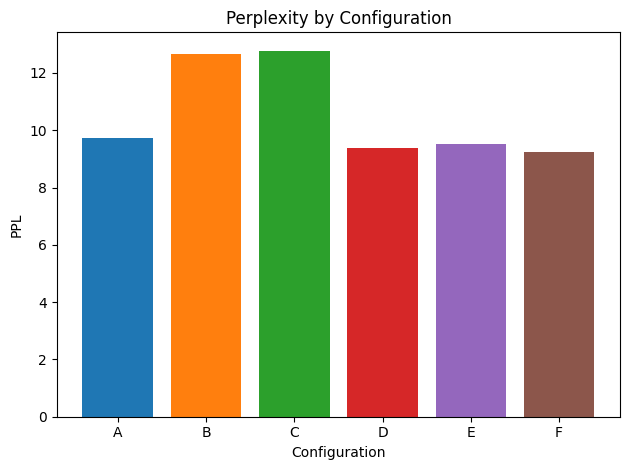

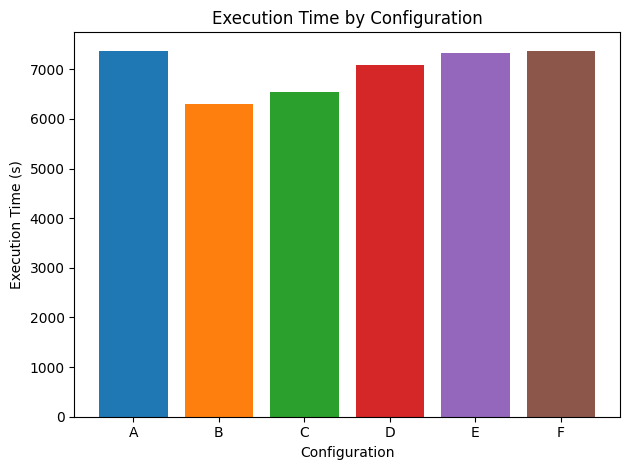

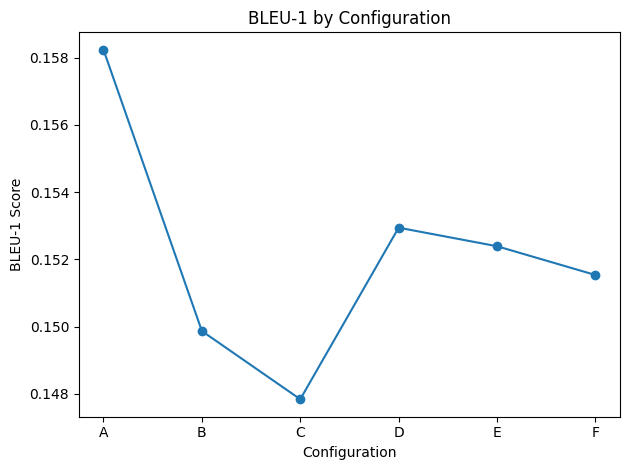

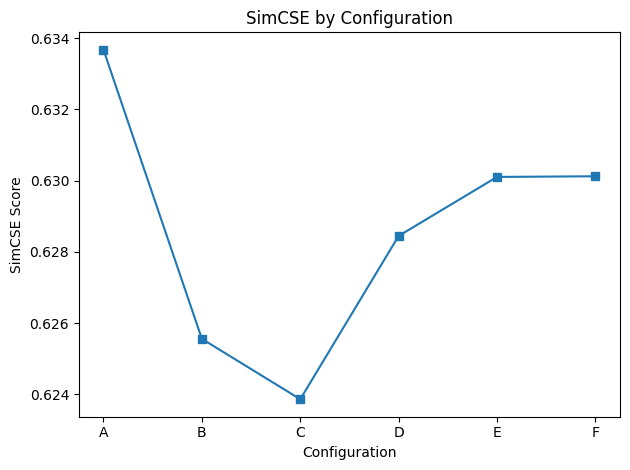

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Short names for each configuration, with new run as 'F'
configs = [
    'A',  # Def Prompt Def Encode
    'B',  # Adj Prompt Def Encode
    'C',  # Adj Prompt Adj Encode
    'D',  # Det Prompt Def Encode
    'E',  # Det Prompt Adj Encode
    'F'   # Det Prompt Adj Temp (new run)
]

# Metric values including the new run
ppl = [
    9.72072209317118,
    12.65756098957205,
    12.778519409967156,
    9.378354926148507,
    9.516156815340551,
    9.255758371527383  # new run
]

execution_time = [
    7377.300039052963,
    6298.124134063721,
    6543.124329328537,
    7093.323058128357,
    7339.473012447357,
    7361.822386026382  # new run
]

avg_bleu1 = [
    0.1582303344329397,
    0.14987015031882067,
    0.14784236862969116,
    0.15294261026697234,
    0.15239120979895907,
    0.15153644940613223  # new run
]

avg_simcse = [
    0.6336752,
    0.6255573,
    0.6238615,
    0.6284481,
    0.63010496,
    0.63012373  # new run
]

# Build DataFrame
df = pd.DataFrame({
    'Config': configs,
    'PPL': ppl,
    'Execution Time (s)': execution_time,
    'BLEU-1': avg_bleu1,
    'SimCSE': avg_simcse
})

# Distinct colors for bar charts
colors = plt.cm.tab10(np.arange(len(df)))

# 1) PPL bar chart
plt.figure()
plt.bar(df['Config'], df['PPL'], color=colors)
plt.xlabel('Configuration')
plt.ylabel('PPL')
plt.title('Perplexity by Configuration')
plt.tight_layout()
plt.show()

# 2) Execution Time bar chart
plt.figure()
plt.bar(df['Config'], df['Execution Time (s)'], color=colors)
plt.xlabel('Configuration')
plt.ylabel('Execution Time (s)')
plt.title('Execution Time by Configuration')
plt.tight_layout()
plt.show()

# 3) BLEU-1 line plot
plt.figure()
plt.plot(df['Config'], df['BLEU-1'], marker='o', linestyle='-')
plt.xlabel('Configuration')
plt.ylabel('BLEU-1 Score')
plt.title('BLEU-1 by Configuration')
plt.tight_layout()
plt.show()

# 4) SimCSE line plot
plt.figure()
plt.plot(df['Config'], df['SimCSE'], marker='s', linestyle='-')
plt.xlabel('Configuration')
plt.ylabel('SimCSE Score')
plt.title('SimCSE by Configuration')
plt.tight_layout()
plt.show()